In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [4]:
DATASET_ID = 'buckeye'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'words_full_length.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,rate,spectrogram
0,24.457298,24.722471,uh,[ah],[0.0],[0.2651729999999972],0,0,0,s25,0,o,f,s2501b,16000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,24.722471,24.900012,it's,"[ih, t, s]","[0.0, 0.06952900000000284, 0.12518900000000244]","[0.06952900000000284, 0.12518900000000244, 0.1...",1,1,1,s25,0,o,f,s2501b,16000,"[[182, 182, 183, 182, 181, 178, 174, 170, 169,..."
2,24.900012,25.121935,all,"[ao, l]","[0.0, 0.17070899999999867]","[0.17070899999999867, 0.22192300000000031]",4,2,2,s25,0,o,f,s2501b,16000,"[[104, 110, 118, 124, 128, 128, 125, 129, 138,..."


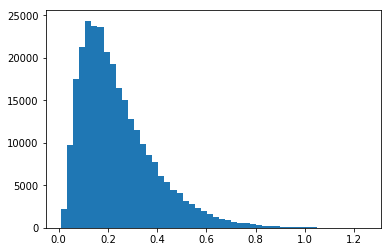

In [87]:
plt.hist(syllable_df.end_time.values - syllable_df.start_time.values, bins=50);

In [9]:
len(syllable_df)

283533

In [10]:
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,s25,s08,s24,s40,s15,s17,s13,s16,s26,s35,...,s32,s01,s14,s28,s29,s31,s39,s04,s33,s21
0,8445,7738,7425,7006,8273,5228,9177,11664,4446,8774,...,5566,4678,8403,7060,8428,5198,6805,7015,5688,4905


In [11]:
freq_words = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.word == i)] for i in tqdm(syllable_df.word.unique())}
    )
    .T.sort_values(by=0, ascending=False)
    .T
)

In [12]:
freq_words.T[:30].T

,i,and,the,to,a,that,it,of,you,like,...,um,don't,have,is,my,for,know,think,he,we
0,11986,10900,8306,6389,6101,5792,4555,4322,4308,4060,...,2409,2207,2106,1869,1859,1812,1776,1760,1708,1700


In [13]:
print(list(freq_words.columns[:200]))

['i', 'and', 'the', 'to', 'a', 'that', 'it', 'of', 'you', 'like', 'uh', 'yknow', 'in', 'they', 'was', 'but', "it's", 'so', 'yeah', 'just', 'um', "don't", 'have', 'is', 'my', 'for', 'know', 'think', 'he', 'we', 'there', 'do', 'on', 'or', 'not', 'be', 'mean', 'with', 'because', "that's", 'what', 'really', 'people', 'well', 'all', 'if', "i'm", 'this', 'out', 'at', 'get', 'about', 'them', 'are', 'go', 'when', 'she', 'me', 'one', 'then', 'had', 'as', 'up', 'um-hum', 'would', 'right', "they're", 'lot', 'no', 'oh', 'more', 'got', 'were', 'can', 'some', 'things', "there's", 'said', 'now', 'something', 'time', 'school', 'from', "you're", 'your', 'him', "didn't", 'been', 'say', 'where', 'gonna', 'see', "he's", 'their', 'thing', 'how', 'here', 'her', 'kids', 'much', "i've", 'kind', 'two', 'back', 'an', 'going', 'very', 'want', 'way', 'even', 'too', 'good', 'other', 'years', 'did', 'went', 'little', "can't", 'stuff', 'down', 'his', 'could', 'work', 'over', 'has', 'always', 'those', 'doing', 'diffe

### find words with high overlap in phones

In [120]:
word_phones_df = pd.DataFrame(
    {
        word: [
            syllable_df[syllable_df.word == word].iloc[0].phones,
            sum(syllable_df.word == word),
        ]
        for word in tqdm(syllable_df.word.unique())
    }
).T
word_phones_df.columns = ["phones", "count"]


KeyboardInterrupt: 

In [123]:
word_phones_df.sort_values(by='count', ascending=False)[:20]

,phones,count
i,[ay],11986
and,"[eh, n]",10900
the,"[dh, ih]",8306
to,"[t, ah]",6389
a,[ah],6101
that,"[dh, eh, t]",5792
it,"[ah, t]",4555
of,[ih],4322
you,"[y, uw]",4308
like,"[ay, k]",4060


In [25]:
ensure_dir(DATA_DIR/'umap_windows' / DATASET_ID)
word_phones_df.to_pickle(DATA_DIR/'umap_windows' / DATASET_ID / 'words_phones_freq.pickle')

In [15]:
import numpy as np    
from scipy.spatial.distance import pdist, squareform
from nltk.metrics.distance import edit_distance

In [16]:
# my list of strings
strings = list(freq_words.columns[:200])

# prepare 2 dimensional array M x N (M entries (3) with N dimensions (1)) 
transformed_strings = np.array(strings).reshape(-1,1)

# calculate condensed distance matrix by wrapping the Levenshtein distance function
distance_matrix = pdist(transformed_strings,lambda x,y: edit_distance(x[0],y[0]))

In [17]:
# get square matrix
sqdist = squareform(distance_matrix)

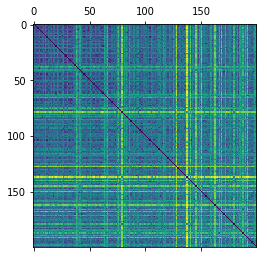

In [18]:
plt.matshow(sqdist)

In [19]:
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

In [20]:
linkage_matrix = linkage(sqdist, "single")

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


In [21]:
dn = dendrogram(
    linkage_matrix,
    p=6,
    truncate_mode="none",
    get_leaves=True,
    orientation="left",
    no_labels=True,
    link_color_func=lambda k: "k",
    show_contracted=False,
    no_plot=True
)

In [22]:
print([strings[leaf] for li, leaf in enumerate(dn['leaves'])])

['everything', 'different', "wouldn't", 'columbus', 'probably', 'actually', 'getting', 'something', 'anything', 'whatever', "they're", "there's", 'through', 'thought', 'because', 'um-hum', "that's", "doesn't", 'parents', 'little', 'stuff', 'still', "didn't", "wasn't", 'right', 'first', 'things', 'which', 'think', 'thing', 'maybe', 'house', 'yknow', 'never', 'every', 'money', 'being', "can't", 'wanna', "don't", 'gonna', 'going', 'doing', "she's", "we're", 'other', 'those', 'their', 'where', 'three', 'there', 'these', 'years', 'okay', 'only', "he's", 'said', 'back', 'want', 'went', 'much', 'have', 'take', 'make', 'same', 'time', "i've", 'five', 'live', 'like', 'life', 'this', 'what', 'that', 'than', 'when', 'then', 'they', 'them', 'get', 'yes', 'all', 'know', 'one', 'from', 'done', 'more', 'home', 'some', 'come', 'down', 'work', 'good', 'look', 'her', 'are', 'see', 'the', 'she', 'he', 'we', 'be', 'me', 'just', 'most', 'many', 'him', 'his', 'your', 'in', 'it', 'is', 'i', 'if', 'big', 'did

In [118]:
similarity_plots = [
    ["than", "when", "then", "they", "them"],
    ["where", "there", "their"],
    ["real", "feel"],
    ["five", "live", "i've"],
    ["way", "say", "day"],
]

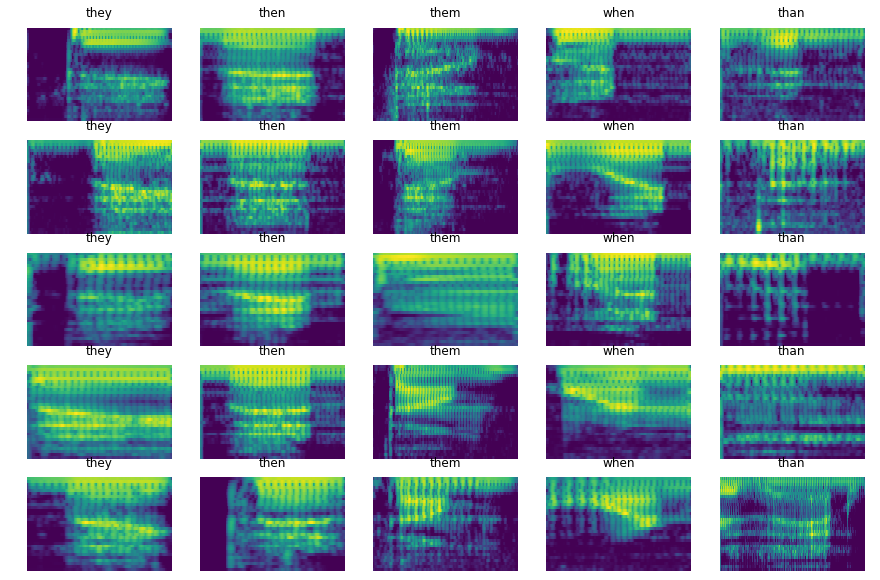

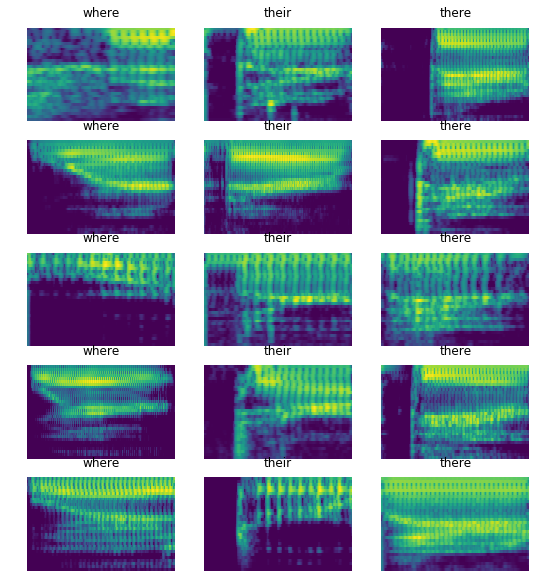

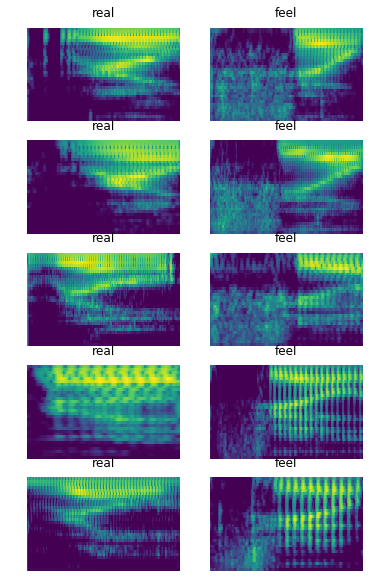

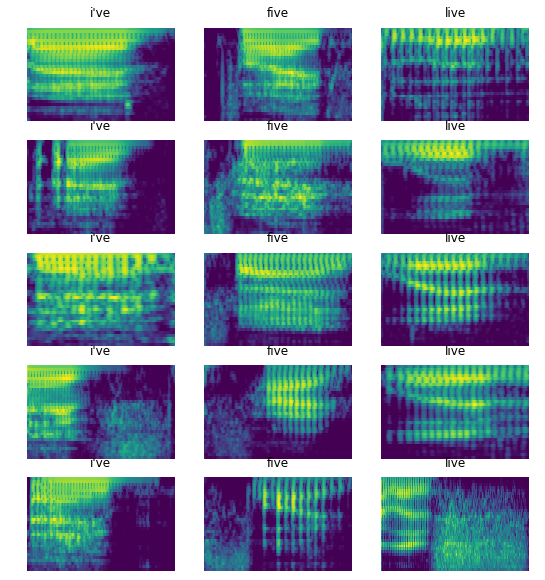

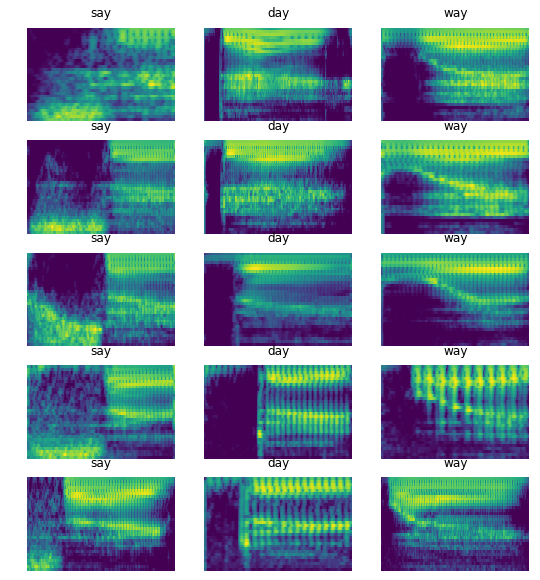

In [119]:
for words in similarity_plots:
    
    # subset syllables of interest
    words_df = syllable_df[syllable_df.word.isin(words)]
    ncols = len(words_df.word.unique())
    nrows = 5
    fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=((ncols)*3, nrows*2))
    for row in range(nrows):
        for wi, word in enumerate(words_df.word.unique()):
            ax = axs[row, wi]
            spec = words_df[words_df.word == word].spectrogram.values[row]
            ax.matshow(spec, aspect='auto')
            ax.set_title(word)
            ax.axis('off')
    plt.show()

In [110]:
# get spectrograms of words, window each spectrogram, save onsets and offsets of spectrograms as numpy arrays

In [111]:
from itertools import islice

def window(seq, n=2, skip = 100):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [124]:
similarity_plots = [["way", "say", "day"]]

In [135]:
window_length_ms = 5
hop_length_ms = 0.5
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

10

In [136]:
for words in similarity_plots:
    
    # skip if already created
    save_loc = (
        DATA_DIR
        / "umap_windows"
        / DATASET_ID
        / ("_".join(words) + "_" + str(window_length_ms) + '.pickle')
    )
    if save_loc.exists():
        continue
    
    # subset syllables of interest
    words_df = syllable_df[syllable_df.word.isin(words)]
    # get spectrograms for words
    windows = [np.array([i for i in window(row.spectrogram.T, n=window_length_frames)]) for idx, row in tqdm(words_df.iterrows(), total=len(words_df))]
    words_df['windows'] = windows
    
    # save windows to dataframe
    ensure_dir(DATA_DIR / "umap_windows" / DATASET_ID)
    print(save_loc)
    words_df.to_pickle(save_loc)
    break

/local/home/tsainbur/github_repos/avgn_paper/data/umap_windows/buckeye/way_say_day_5.pickle


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [137]:
print(save_loc)

/local/home/tsainbur/github_repos/avgn_paper/data/umap_windows/buckeye/way_say_day_5.pickle


In [138]:
words_df[:3]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,rate,spectrogram,windows
445,236.236188,236.352105,say,"[s, eh]","[0.0, 0.060875000000010004]","[0.060875000000010004, 0.11591699999999605]",74,31,31,s25,0,o,f,s2501b,16000,"[[0, 0, 0, 1, 2, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1..."
492,250.321120,250.586825,say,"[s, ey]","[0.0, 0.1448169999999891]","[0.1448169999999891, 0.26570499999999697]",17,10,10,s25,0,o,f,s2501b,16000,"[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[1, 0, 20, 43, 30, 3, 0, 0, 0, 0, 0, 0, 2, 2..."
610,293.978018,294.234862,say,"[s, ey]","[0.0, 0.13373199999995222]","[0.13373199999995222, 0.25684400000000096]",22,9,9,s25,0,o,f,s2501b,16000,"[[146, 146, 145, 144, 143, 141, 138, 134, 130,...","[[[146, 108, 68, 121, 120, 92, 70, 72, 79, 88,..."


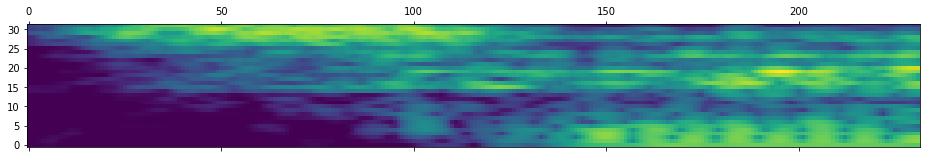

In [139]:
plt.matshow(words_df.iloc[0].spectrogram, origin='lower')

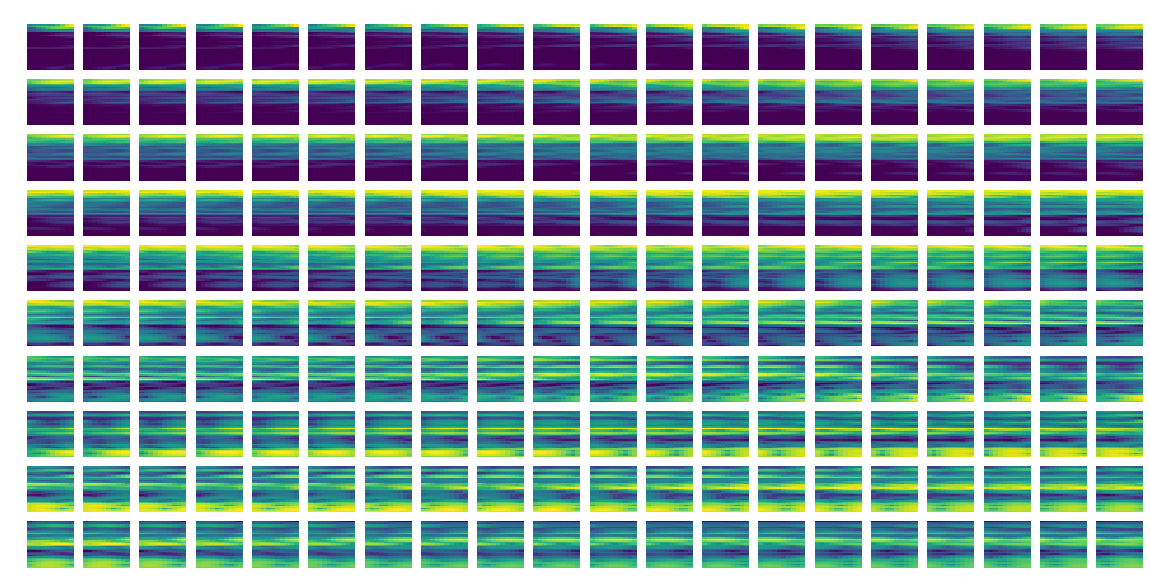

In [140]:
ncols = 20
nrows = 10
zm = 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(zm*ncols, zm*nrows))
for axi in tqdm(range(ncols*nrows)):
    ax = axs.flatten()[axi]
    ax.matshow(windows[0][axi].T, aspect='auto', origin='lower')
    ax.axis('off')

In [92]:
words_df[:5]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,rate,spectrogram,windows
4,25.588546,25.778605,they,"[dh, ey]","[0.0, 0.06714699999999851]","[0.06714699999999851, 0.19005899999999798]",10,4,4,s25,0,o,f,s2501b,16000,"[[3, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[3, 23, 38, 44, 47, 47, 44, 36, 20, 8, 0, 1,..."
26,33.108949,33.305837,they,"[dh, ey]","[0.0, 0.08692599999999828]","[0.08692599999999828, 0.19688799999999418]",11,6,6,s25,0,o,f,s2501b,16000,"[[48, 83, 111, 130, 143, 152, 158, 162, 165, 1...","[[[48, 111, 142, 139, 134, 135, 136, 124, 81, ..."
69,48.811535,48.956812,then,"[n, eh, n]","[0.0, 0.018174999999999386, 0.11372099999999818]","[0.018174999999999386, 0.11372099999999818, 0....",2,1,1,s25,0,o,f,s2501b,16000,"[[205, 205, 203, 202, 200, 198, 196, 194, 193,...","[[[205, 199, 141, 98, 153, 150, 127, 113, 117,..."
84,54.420270,54.759360,them,"[dh, eh, m]","[0.0, 0.06698699999999747, 0.23886999999999858]","[0.06698699999999747, 0.23886999999999858, 0.3...",18,5,5,s25,0,o,f,s2501b,16000,"[[31, 30, 29, 26, 22, 18, 14, 11, 9, 7, 5, 5, ...","[[[31, 15, 1, 0, 0, 10, 29, 34, 28, 8, 0, 0, 0..."
94,56.720679,56.811552,they,"[dh, ey]","[0.0, 0.02804100000000176]","[0.02804100000000176, 0.09087300000000198]",48,16,16,s25,0,o,f,s2501b,16000,"[[149, 150, 150, 152, 154, 156, 157, 157, 157,...","[[[149, 133, 111, 128, 161, 180, 185, 177, 164..."
